# Model Loading

In [2]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
import argparse
import logging
from datetime import datetime, timedelta, date
import torch
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch_geometric.utils.convert import from_networkx

In [3]:
from networks_pyg.GCN import *
from datasets.Myloader import simulation_loader
from optim import Mytrainer
from optim.loss import loss_function,init_center
from datasets import dataloader_pyg as dataloader
from datasets import Myloader
from networks_pyg.init import init_model
from optim.loss_my import anomaly_score

from sklearn.metrics import *

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
parser = argparse.ArgumentParser(description='OCGNN')
parser.add_argument("--dataset", type=str, default='cora',
        help="dataset")
parser.add_argument("--dropout", type=float, default=0.25,
        help="dropout probability")
parser.add_argument("--nu", type=float, default=0.01, # 0.2
        help="hyperparameter nu (must be 0 < nu <= 1)")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")
parser.add_argument("--seed", type=int, default=52,
        help="random seed, -1 means dont fix seed")
parser.add_argument("--module", type=str, default='GraphSAGE',
        help="GCN/GAT/GIN/GraphSAGE/GAE")
parser.add_argument('--n-worker', type=int,default=1,
        help='number of workers when dataloading')
parser.add_argument('--batch-size', type=int,default=128,
        help='batch size')
parser.add_argument("--lr", type=float, default=1e-3,
        help="learning rate")
parser.add_argument("--normal-class", type=int, default=0,
        help="normal class")
parser.add_argument("--n-epochs", type=int, default=100,
        help="number of training epochs")
parser.add_argument("--n-hidden", type=int, default=32,
        help="number of hidden gnn units")
parser.add_argument("--n-layers", type=int, default=2,
        help="number of hidden gnn layers")
parser.add_argument("--weight-decay", type=float, default=5e-4,
        help="Weight for L2 loss")
parser.add_argument('--early-stop', action='store_true', default=False,
                    help="indicates whether to use early stop or not")
parser.add_argument("--self-loop", action='store_true',
        help="graph self-loop (default=False)")
parser.add_argument("--norm", action='store_true',
        help="graph normalization (default=False)")
parser.set_defaults(self_loop=True)
parser.set_defaults(norm=False)
# args = parser.parse_args()
args = parser.parse_args(args=[])
# if args.module=='GCN':
#     #args.self_loop=True
#     args.norm=True
# if args.module=='GAE':
#     args.lr=0.002
#     args.dropout=0.
#     args.weight_decay=0.
#     # args.n_hidden=32
# #     args.self_loop=True
# # if args.module=='GraphSAGE':
# #     args.self_loop=True


In [6]:
## https://github.com/mangushev/mtad-tf/blob/main/evaluate.py
#just like onmianomaly, no delta. If we hit anuthing in anomaly interval, whole anomaly segment is correctly identified
#-----------------------
#1|0|1|1|1|0|0|0|1|1|1|1  Labels
#-----------------------
#0|0|0|1|1|0|0|0|0|0|1|0  Predictions
#-----------------------
#0|0|1|1|1|0|0|0|1|1|1|1  Adjusted
#-----------------------
def adjust_predictions(predictions, labels):
  adjustment_started = False
  new_pred = predictions

  for i in range(len(predictions)):
    if labels[i] == 1:
      if predictions[i] == 1:
        if not adjustment_started:
          adjustment_started = True
          for j in range(i, 0, -1):
            if labels[j] == 1:
              new_pred[j] = 1
            else:
              break
    else:
      adjustment_started = False

    if adjustment_started:
      new_pred[i] = 1
      
  return new_pred

In [7]:
def evaluate(label_all, score_all, adjust = False, plot=False, print_=False):
    true = label_all
    pred = list(map(int, [s>0 for s in score_all]))
    if adjust:
        pred = adjust_predictions(pred, true)
    CM = confusion_matrix(true, pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    acc = accuracy_score(true, pred)
    auc = roc_auc_score(true, pred)
#     far = FP / (FP+TN)
    far = FP / (TP+FP)
    pre = precision_score(true, pred, pos_label=1)
    rec = recall_score(true, pred, pos_label=1)
    macro_f1 = f1_score(true, pred, average='macro')
    ap = average_precision_score(true, pred)
    if plot:
        plt.figure(figsize=(40, 5))
        plt.plot(true)
        plt.plot(pred)
    if print_:
        print('Accuracy \t{:.4f}'.format(accuracy_score(true, pred)))
        print('AUC score \t{:.4f}'.format(roc_auc_score(true, pred)))
        print('FAR score \t{:.4f}'.format(far))
        print('Precision \t{:.4f}'.format(precision_score(true, pred, pos_label=1)))
        print('Recall   \t{:.4f}'.format(recall_score(true, pred, pos_label=1)))
        print('Macro F1 \t{:.4f}'.format(f1_score(true, pred, average='macro')))
        print('Avg Precision \t{:.4f}'.format(ap))
        print(classification_report(true, pred))
    return [acc, auc, far, pre, rec, macro_f1, ap]

## All Results

In [7]:
result_all = []

for normalize in ['standard']:
    # data
    args.dataset = 'simulation'
    args.normalize = normalize
    train_loader, val_loader, test_loader, input_dim = Myloader.simulation_loader(args)
    print(len(train_loader), len(val_loader), len(test_loader))

    for nu in [0.05, 0.1, 0.2]:
        # for module in ['GCN_gc', 'GCN_traffic', 'GraphSAGE_gc']:
        for name, module in zip(['GCN_sum', 'GCN_rev_sum', 'GraphSAGE_sum'], ['GCN_gc', 'GCN_traffic', 'GraphSAGE_gc']):
            args.module=module
            args.nu = nu
            train_mode = 'all' # all. select
            # args.exp_name = f'{args.normalize}_{train_mode}_{args.module}_{args.nu}_1902'
            args.exp_name = f'{args.dataset}_{name}_{args.nu}'


            checkpoints_path=f'./checkpoints_simul/{args.exp_name}+bestcheckpoint.pt'
            # checkpoints_path=f'./checkpoints/{args.exp_name}+epoch1.pt'
        #     logging.basicConfig(filename=f"./log/{args.exp_name}.log",filemode="a",format="%(asctime)s-%(name)s-%(levelname)s-%(message)s",level=logging.INFO)
        #     logger=logging.getLogger('OCGNN')
            print("##############################")
            print(checkpoints_path)
            # print(args)

            # model
            input_dim = 12
            model = init_model(args, input_dim)
            model.load_state_dict(torch.load(checkpoints_path)['model'])
            model.eval()
            data_center = torch.load(checkpoints_path)['data_center']
            radius = torch.load(checkpoints_path)['radius']
            # print(radius)

            out_all, dist_all, score_all = [], [], []
            for ix, data in tqdm(enumerate(val_loader)):
                output = model(data.cuda())
                out_all.append(output.cpu().detach().numpy())
                dist, _ = anomaly_score(data_center, output, radius)
                dist_all.append(dist.cpu().detach().numpy())
                # score_all.append(score.cpu().detach().numpy())
            dist_all = np.concatenate(dist_all)
            new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
            print(radius, new_radius)


            out_all, dist_all, score_all = [], [], []
            label_all = []
            for ix, data in tqdm(enumerate(test_loader)):
                output = model(data.cuda())
                out_all.append(output.cpu().detach().numpy())
                label_all.append(data.y.cpu().detach().numpy())
                dist, score = anomaly_score(data_center, output, new_radius) # new_radius
                dist_all.append(dist.cpu().detach().numpy())
                score_all.append(score.cpu().detach().numpy())
            label_all = np.concatenate(label_all)
            score_all = np.concatenate(score_all)
            dist_all = np.concatenate(dist_all)

            acc, auc, far, pre, rec, macro_f1, ap = evaluate(label_all, score_all, adjust=False, plot=False)
            result_all.append([args.module, args.normalize, args.nu, False, acc, auc, far, pre, rec, macro_f1, ap])
            acc, auc, far, pre, rec, macro_f1, ap = evaluate(label_all, score_all, adjust=True, plot=False)
            result_all.append([args.module, args.normalize, args.nu, True, acc, auc, far, pre, rec, macro_f1, ap])

train dataset


100%|██████████| 23974/23974 [00:05<00:00, 4304.03it/s]


val dataset


100%|██████████| 3425/3425 [00:01<00:00, 2944.77it/s]


test dataset


100%|██████████| 6850/6850 [00:01<00:00, 3683.71it/s]


188 27 54
##############################
./checkpoints_simul/simulation_GCN_sum_0.05+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7072


27it [00:01, 18.12it/s]


tensor(0.1661, device='cuda:0', dtype=torch.float64) 0.24811676144599915


54it [00:00, 95.67it/s]


##############################
./checkpoints_simul/simulation_GCN_rev_sum_0.05+bestcheckpoint.pt
Parameter number of GCN_traffic Net is: 9152


27it [00:00, 113.63it/s]


tensor(0.0612, device='cuda:0', dtype=torch.float64) 0.09612819999456405


54it [00:00, 97.72it/s] 


##############################
./checkpoints_simul/simulation_GraphSAGE_sum_0.05+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 13984


27it [00:00, 61.93it/s]


tensor(0.3726, device='cuda:0', dtype=torch.float64) 1.5653025865554806


54it [00:00, 87.08it/s]


##############################
./checkpoints_simul/simulation_GCN_sum_0.1+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7072


27it [00:00, 122.94it/s]


tensor(0.0150, device='cuda:0', dtype=torch.float64) 0.004261137172579765


54it [00:00, 112.01it/s]


##############################
./checkpoints_simul/simulation_GCN_rev_sum_0.1+bestcheckpoint.pt
Parameter number of GCN_traffic Net is: 9152


27it [00:00, 115.20it/s]


tensor(0.0941, device='cuda:0', dtype=torch.float64) 0.033840810507535936


54it [00:00, 108.65it/s]


##############################
./checkpoints_simul/simulation_GraphSAGE_sum_0.1+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 13984


27it [00:00, 88.28it/s]


tensor(0.2210, device='cuda:0', dtype=torch.float64) 0.6607780218124387


54it [00:00, 88.49it/s]


##############################
./checkpoints_simul/simulation_GCN_sum_0.2+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7072


27it [00:00, 102.42it/s]


tensor(0.0199, device='cuda:0', dtype=torch.float64) 0.0666602224111557


54it [00:00, 93.04it/s] 


##############################
./checkpoints_simul/simulation_GCN_rev_sum_0.2+bestcheckpoint.pt
Parameter number of GCN_traffic Net is: 9152


27it [00:00, 100.62it/s]


tensor(0.3130, device='cuda:0', dtype=torch.float64) 0.5694103598594669


54it [00:00, 97.97it/s] 


##############################
./checkpoints_simul/simulation_GraphSAGE_sum_0.2+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 13984


27it [00:00, 75.44it/s]


tensor(0.3786, device='cuda:0', dtype=torch.float64) 0.26933338046073924


54it [00:00, 75.83it/s]


In [8]:
result_all = pd.DataFrame(result_all, columns=['model', 'normalize', 'nu', 'adjust', 'acc', 'AUC', 'far', 'precision', 'recall', 'F1_score', 'AP'])
result_all


,model,normalize,nu,adjust,acc,AUC,far,precision,recall,F1_score,AP
0,GCN_gc,standard,0.05,False,0.916496,0.683719,0.409611,0.590389,0.396313,0.714456,0.291351
1,GCN_gc,standard,0.05,True,0.920584,0.705224,0.384946,0.615054,0.439324,0.734658,0.323493
2,GCN_traffic,standard,0.05,False,0.916496,0.658285,0.391185,0.608815,0.339478,0.695404,0.269453
3,GCN_traffic,standard,0.05,True,0.920876,0.681327,0.361323,0.638677,0.385561,0.719009,0.304643
4,GraphSAGE_gc,standard,0.05,False,0.941752,0.723794,0.129412,0.870588,0.454685,0.782991,0.447668
5,GraphSAGE_gc,standard,0.05,True,0.946569,0.749139,0.117962,0.882038,0.505376,0.806852,0.492768
6,GCN_gc,standard,0.10,False,0.934745,0.836778,0.359890,0.640110,0.715822,0.819786,0.485212
7,GCN_gc,standard,0.10,True,0.937664,0.852139,0.350267,0.649733,0.746544,0.830035,0.509141
8,GCN_traffic,standard,0.10,False,0.956058,0.907670,0.267905,0.732095,0.847926,0.880642,0.635216
9,GCN_traffic,standard,0.10,True,0.957226,0.913815,0.265092,0.734908,0.860215,0.884397,0.645464


In [24]:
result_all[result_all.adjust==True]

,model,normalize,nu,adjust,acc,AUC,far,precision,recall,F1_score,AP
1,GCN_gc,standard,0.05,True,0.920584,0.705224,0.384946,0.615054,0.439324,0.734658,0.323493
3,GCN_traffic,standard,0.05,True,0.920876,0.681327,0.361323,0.638677,0.385561,0.719009,0.304643
5,GraphSAGE_gc,standard,0.05,True,0.946569,0.749139,0.117962,0.882038,0.505376,0.806852,0.492768
7,GCN_gc,standard,0.10,True,0.937664,0.852139,0.350267,0.649733,0.746544,0.830035,0.509141
9,GCN_traffic,standard,0.10,True,0.957226,0.913815,0.265092,0.734908,0.860215,0.884397,0.645464
11,GraphSAGE_gc,standard,0.10,True,0.972409,0.944200,0.180055,0.819945,0.909370,0.923507,0.754246
13,GCN_gc,standard,0.20,True,0.842190,0.905247,0.625731,0.374269,0.983103,0.723404,0.369551
15,GCN_traffic,standard,0.20,True,0.844234,0.909126,0.622066,0.377934,0.989247,0.726436,0.374892
17,GraphSAGE_gc,standard,0.20,True,0.852847,0.914572,0.608379,0.391621,0.990783,0.736476,0.388888


In [9]:
result_all.to_csv('result/simulation_sumpool.csv')

Accuracy 	0.9420
AUC score 	0.8580
FAR score 	0.3255
Precision 	0.6745
Recall   	0.7542
Macro F1 	0.8399
Avg Precision 	0.5320
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      6199
           1       0.67      0.75      0.71       651

    accuracy                           0.94      6850
   macro avg       0.82      0.86      0.84      6850
weighted avg       0.95      0.94      0.94      6850



[0.9420437956204379,
 0.8579961487272241,
 0.32554945054945056,
 0.6744505494505495,
 0.7542242703533026,
 0.8399444071003956,
 0.5320446377823014]

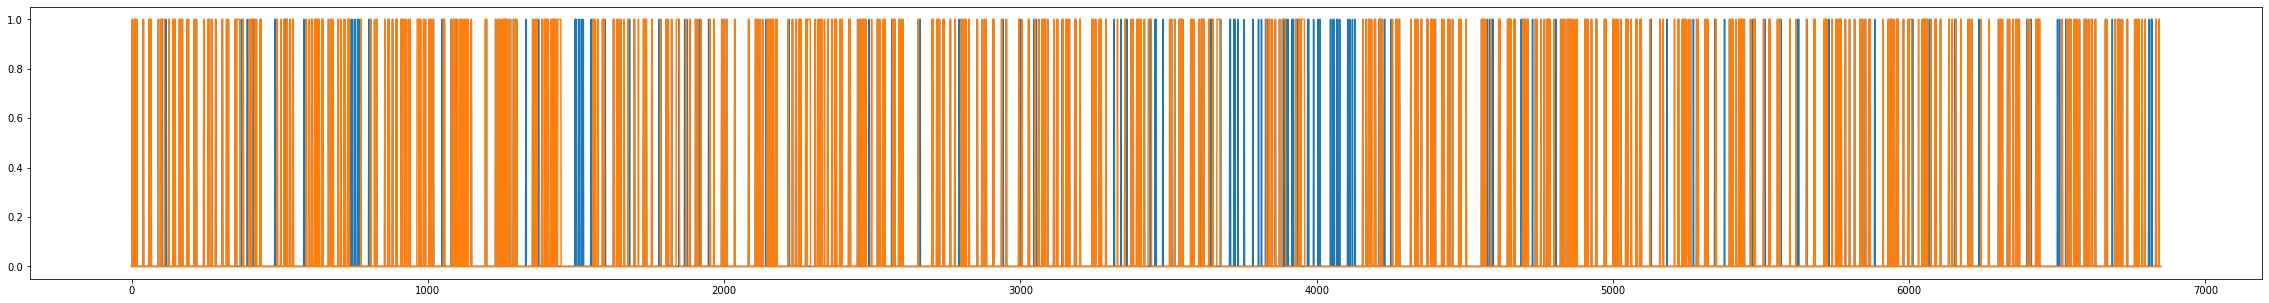

In [15]:
evaluate(label_all, score_all, adjust=False, plot=True, print_=True)

Accuracy 	0.9444
AUC score 	0.8703
FAR score 	0.3185
Precision 	0.6815
Recall   	0.7788
Macro F1 	0.8480
Avg Precision 	0.5517
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6199
           1       0.68      0.78      0.73       651

    accuracy                           0.94      6850
   macro avg       0.83      0.87      0.85      6850
weighted avg       0.95      0.94      0.95      6850



[0.9443795620437956,
 0.8702849352095589,
 0.3185483870967742,
 0.6814516129032258,
 0.7788018433179723,
 0.8479593486343955,
 0.5517376700712565]

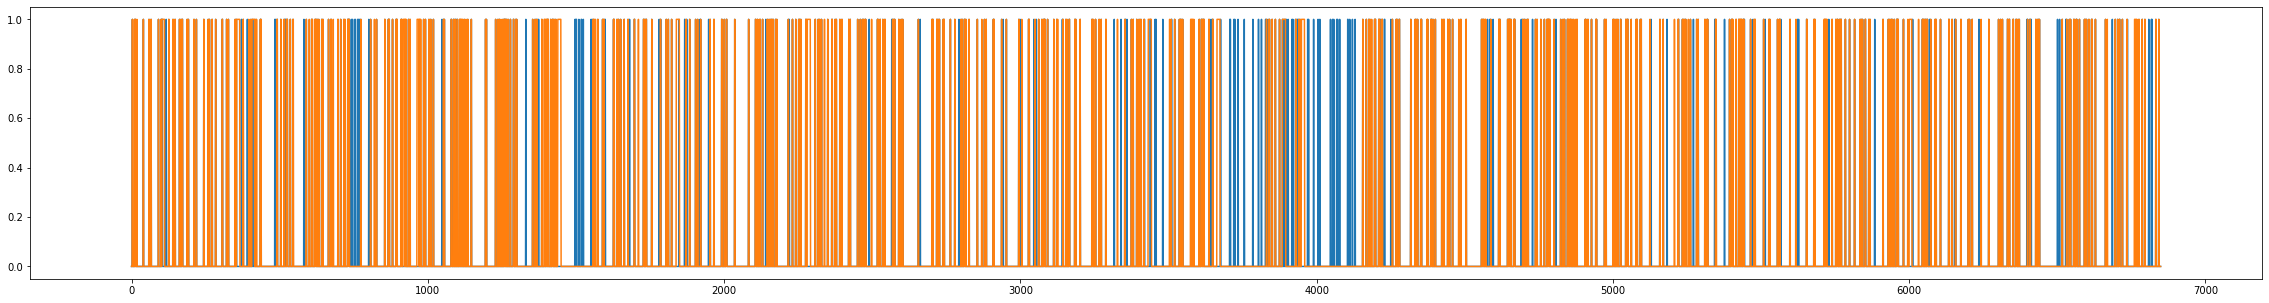

In [16]:
evaluate(label_all, score_all, adjust=True, plot=True, print_=True)

## Case Result

In [10]:
args.dataset = 'simulation'
# args.module = 'GCN_gc'
args.module = 'GraphSAGE_gc'
name = 'GraphSAGE_sum'
args.normalize = 'standard'
args.nu = 0.1
args.exp_name = f'{args.dataset}_{name}_{args.nu}'


In [11]:
checkpoints_path=f'./checkpoints_simul/{args.exp_name}+bestcheckpoint.pt'
logging.basicConfig(filename=f"./log/{args.exp_name}.log",filemode="a",format="%(asctime)s-%(name)s-%(levelname)s-%(message)s",level=logging.INFO)
logger=logging.getLogger('OCGNN')
checkpoints_path

'./checkpoints_simul/simulation_GraphSAGE_sum_0.1+bestcheckpoint.pt'

In [12]:
train_loader, val_loader, test_loader, scaler = simulation_loader(args)
len(train_loader), len(val_loader), len(test_loader)

train dataset


100%|██████████| 23974/23974 [00:05<00:00, 4064.06it/s]


val dataset


100%|██████████| 3425/3425 [00:00<00:00, 4237.74it/s]


test dataset


100%|██████████| 6850/6850 [00:02<00:00, 2919.48it/s]


(188, 27, 54)

In [13]:
input_dim = 12
model = init_model(args, input_dim)
# model_1 = init_model(args, input_dim)
# model_50 = init_model(args, input_dim)
# model_100 = init_model(args, input_dim)

Parameter number of GraphSAGE_gc Net is: 13984


In [14]:
print(checkpoints_path)
model.load_state_dict(torch.load(checkpoints_path)['model'])
model.eval()
data_center = torch.load(checkpoints_path)['data_center']
radius = torch.load(checkpoints_path)['radius']
model, data_center, radius

./checkpoints_simul/simulation_GraphSAGE_sum_0.1+bestcheckpoint.pt


(GraphSAGE_gc(
   (layers): ModuleList(
     (0): SAGEConv(12, 64, aggr=SoftmaxAggregation)
     (1): SAGEConv(64, 64, aggr=SoftmaxAggregation)
   )
   (outlayer): SAGEConv(64, 32, aggr=SoftmaxAggregation)
   (dropout): Dropout(p=0.25, inplace=False)
 ),
 tensor([ 22.9163,  15.1056, -75.4331,   4.3203, -20.4048,  -7.6234,  34.8891,
          90.2353,  29.7373,  31.2185,  45.1525, -52.5697,  18.8506, -63.9019,
         -18.7801, -46.3299,  79.2108,  -6.7675, -31.4487,  18.9676, -85.3702,
          35.4845,  47.2158,  53.8443,  30.6593,  13.2560,  74.7221,  44.0611,
         -11.6198,  64.9610,   2.6381,   0.4358], device='cuda:0'),
 tensor(0.2210, device='cuda:0', dtype=torch.float64))

In [15]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(val_loader)):
    output = model(data.cuda())
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    if ix < 5:
        print(output[0][:2])
    # dist, score = anomaly_score(data_center, output, radius)
    dist = torch.sum((output - data_center) ** 2, dim=1)
    dist_all.append(dist.cpu().detach().numpy())
    # score_all.append(score.cpu().detach().numpy())
# label_all = np.concatenate(label_all)
# score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)
print(dist_all[:5])
new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
new_radius

16it [00:00, 74.66it/s]

tensor([22.8983, 15.0978], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([22.9134, 15.1014], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([22.9183, 15.1098], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([22.9220, 15.1019], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([22.9249, 15.1030], device='cuda:0', grad_fn=<SliceBackward0>)


27it [00:00, 75.93it/s]

[0.01027834 0.00399618 0.01387076 0.01754461 1.527592  ]


0.6607616066932676

In [16]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(test_loader)):
    output = model(data.cuda())
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    dist, score = anomaly_score(data_center, output, new_radius)
    dist_all.append(dist.cpu().detach().numpy())
    score_all.append(score.cpu().detach().numpy())
label_all = np.concatenate(label_all)
score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)

54it [00:00, 69.89it/s]


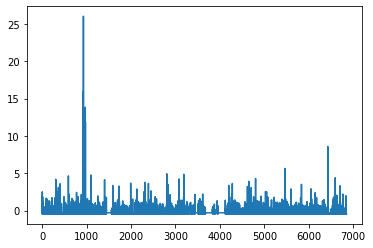

In [17]:
plt.plot(score_all)

In [18]:
# def Cumulative(lists, window=12):
#     cu_list = []
#     length = len(lists)
#     cu_list = [sum(lists[x-window:x]) for x in range(window, length)]
#     return cu_list + [0]*window

# plt.plot(Cumulative(score_all, window=2))
# score_all = Cumulative(score_all, window=2)

Accuracy 	0.9720
AUC score 	0.9419
FAR score 	0.1808
Precision 	0.8192
Recall   	0.9048
Macro F1 	0.9221
Avg Precision 	0.7502
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      6199
           1       0.82      0.90      0.86       651

    accuracy                           0.97      6850
   macro avg       0.90      0.94      0.92      6850
weighted avg       0.97      0.97      0.97      6850



[0.971970802919708,
 0.9418953901935027,
 0.1808066759388039,
 0.8191933240611962,
 0.9047619047619048,
 0.9221411192214112,
 0.7502260071363551]

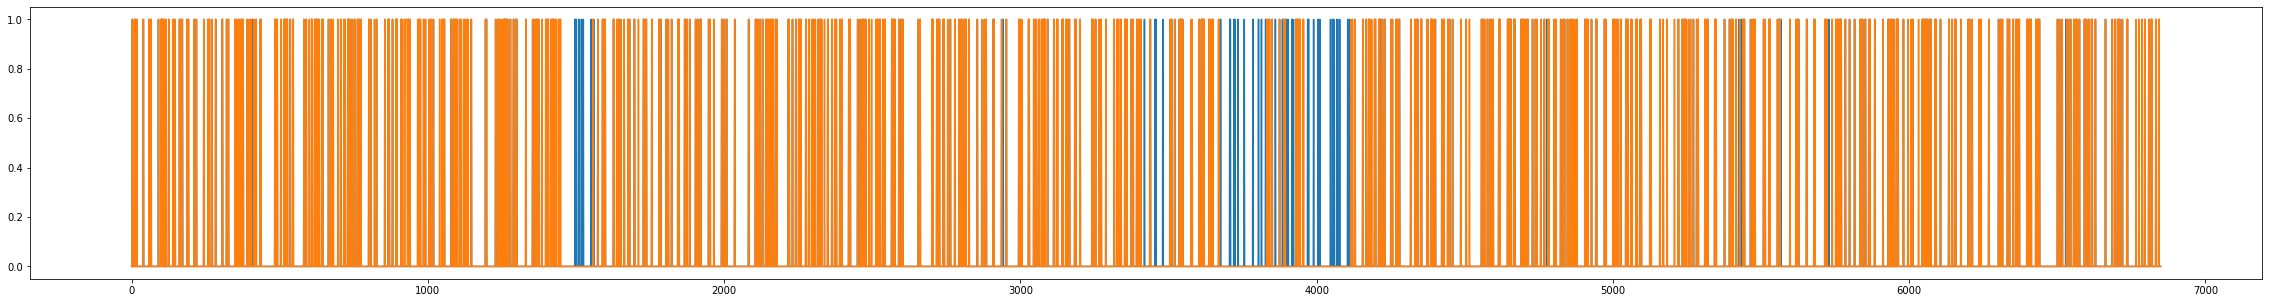

In [19]:
evaluate(label_all, score_all, adjust=False, plot=True, print_=True)

Accuracy 	0.9724
AUC score 	0.9442
FAR score 	0.1801
Precision 	0.8199
Recall   	0.9094
Macro F1 	0.9235
Avg Precision 	0.7542
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      6199
           1       0.82      0.91      0.86       651

    accuracy                           0.97      6850
   macro avg       0.91      0.94      0.92      6850
weighted avg       0.97      0.97      0.97      6850



[0.9724087591240876,
 0.9441995376589405,
 0.18005540166204986,
 0.8199445983379502,
 0.9093701996927803,
 0.923506515904813,
 0.7542463218137296]

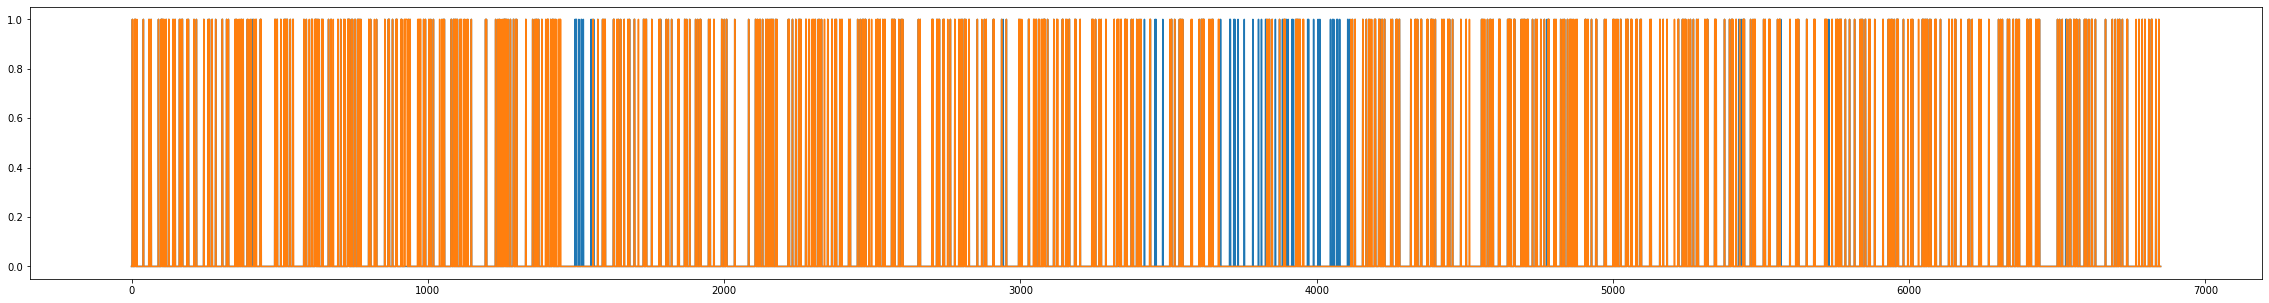

In [20]:
evaluate(label_all, score_all, adjust=True, plot=True, print_=True)

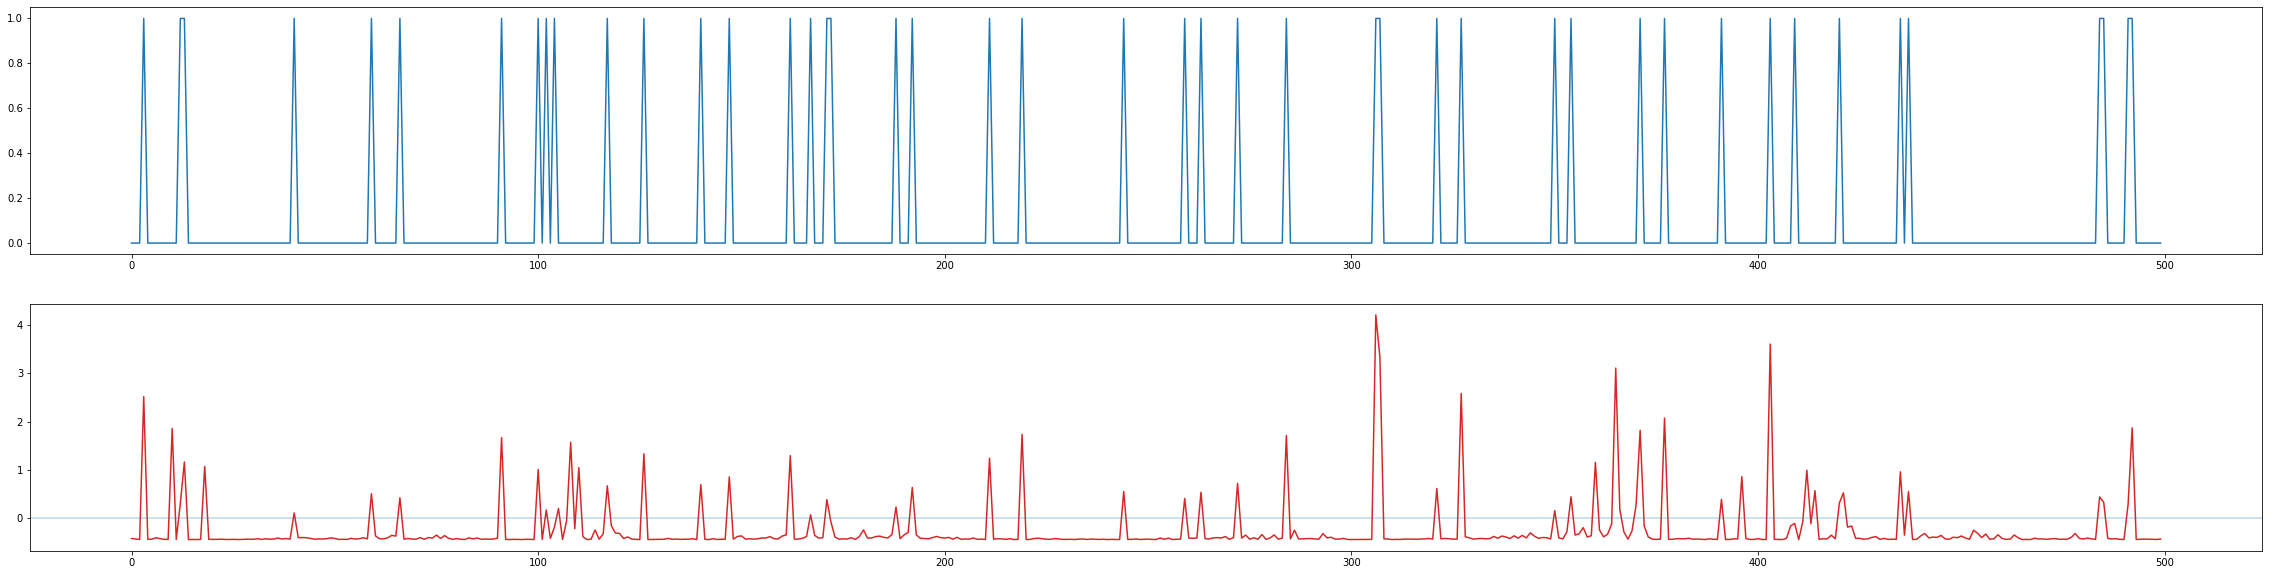

In [23]:
true = label_all
pred = list(map(int, [s>0 for s in score_all]))
plt.figure(figsize=(40, 10))
plt.subplot(2, 1, 1)
plt.plot(true[:500])
plt.subplot(2, 1, 2)
plt.plot(score_all[:500], color='tab:red')
# plt.ylim(-0.005, 0.01)
plt.axhline(0, alpha=0.3)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7feedcfe7c10>
Traceback (most recent call last):
  File "/home/jiin/anaconda3/envs/traffic/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jiin/anaconda3/envs/traffic/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jiin/anaconda3/envs/traffic/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jiin/anaconda3/envs/traffic/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
/tmp/ipykernel_577434/2340417611.py:12: UserWarning: The palette list has more value

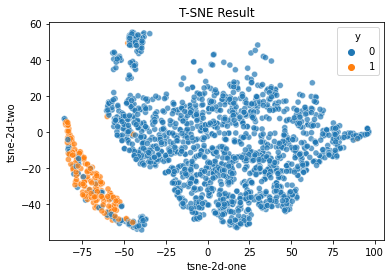

/tmp/ipykernel_577434/2340417611.py:34: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


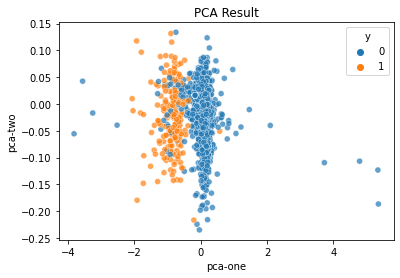

In [68]:
rndperm = np.random.permutation(2000)

## tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_all = tsne.fit_transform(np.concatenate(out_all))

tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
tsne_df['y'] = label_all

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("tab10", 10),
    data=tsne_df.loc[rndperm, :],
    legend="full",
    alpha=0.7
)

plt.title('T-SNE Result')
plt.show()


## PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_all = pca.fit_transform(np.concatenate(out_all))

pca_df = pd.DataFrame(pca_all, columns=['pca-one', 'pca-two'])
pca_df['y'] = label_all

sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("tab10", 10),
    data=pca_df.loc[rndperm, :],
    legend="full",
    alpha=0.7
)

plt.title('PCA Result')
plt.show()

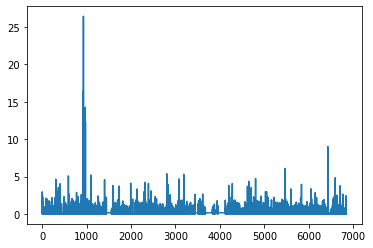

In [27]:
plt.plot(dist_all)

In [29]:
score_all[normal[0]]

array([-0.41359872, -0.42304742, -0.433676  , ..., -0.38559395,
       -0.39277387, -0.415154  ], dtype=float32)

In [30]:
normal = np.where(label_all == 0)
abnormal = np.where(label_all == 1)

Text(0, 0.5, 'Distance')

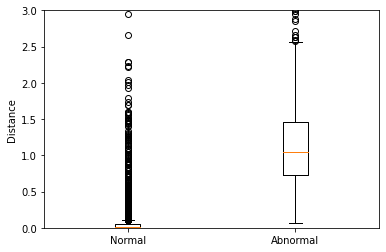

In [69]:
plt.boxplot([dist_all[normal[0]], dist_all[abnormal[0]]])
plt.ylim(0, 3)
plt.xticks([1, 2], ['Normal', 'Abnormal'])
plt.ylabel('Distance')

## Random Case

In [55]:
print(label_all.sum())

651


In [56]:
random_result = []
for i in tqdm(range(20)):
    for nu in [0.05, 0.1, 0.2]:
        true = label_all
        pred = np.random.choice(np.arange(2), len(true), p=[1-nu, nu])
        acc, auc, far, pre, rec, macro_f1, ap = evaluate(label_all, pred, adjust=False, plot=False)
        random_result.append(['random', None, nu, False, acc, auc, far, pre, rec, macro_f1, ap])
        acc, auc, far, pre, rec, macro_f1, ap = evaluate(label_all, pred, adjust=True, plot=False)
        random_result.append(['random', None, nu, True, acc, auc, far, pre, rec, macro_f1, ap])

100%|██████████| 20/20 [00:03<00:00,  6.29it/s]


In [58]:
random_result = pd.DataFrame(random_result, columns=['model', 'normalize', 'nu', 'adjust', 'acc', 'auc', 'far', 'precision', 'recall', 'f1_score', 'AP'])
random_result.groupby([ 'adjust', 'nu',]).mean()

/tmp/ipykernel_3235778/385202225.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  random_result.groupby([ 'adjust', 'nu',]).mean()


acc       auc       far  precision    recall  f1_score  \
adjust nu                                                                  
False  0.05  0.863328  0.499165  0.907612   0.092388  0.049539  0.495353   
       0.10  0.824182  0.499498  0.905815   0.094185  0.098618  0.499465   
       0.20  0.742051  0.502547  0.902840   0.097160  0.206836  0.490352   
True   0.05  0.864255  0.504042  0.891310   0.108690  0.059293  0.501698   
       0.10  0.826175  0.509982  0.888069   0.111931  0.119585  0.509601   
       0.20  0.745474  0.520557  0.887812   0.112188  0.242857  0.501838   

                   AP  
adjust nu              
False  0.05  0.094990  
       0.10  0.095046  
       0.20  0.095539  
True   0.05  0.095968  
       0.10  0.097225  
       0.20  0.099284

Accuracy 	0.8263
AUC score 	0.5108
FAR score 	0.8867
Precision 	0.1133
Recall   	0.1214
Macro F1 	0.5104
Avg Precision 	0.0973
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      6199
           1       0.11      0.12      0.12       651

    accuracy                           0.83      6850
   macro avg       0.51      0.51      0.51      6850
weighted avg       0.83      0.83      0.83      6850



[0.8262773722627738,
 0.5108291337808065,
 0.8866571018651362,
 0.1133428981348637,
 0.12135176651305683,
 0.510435004458726,
 0.09725801054541167]

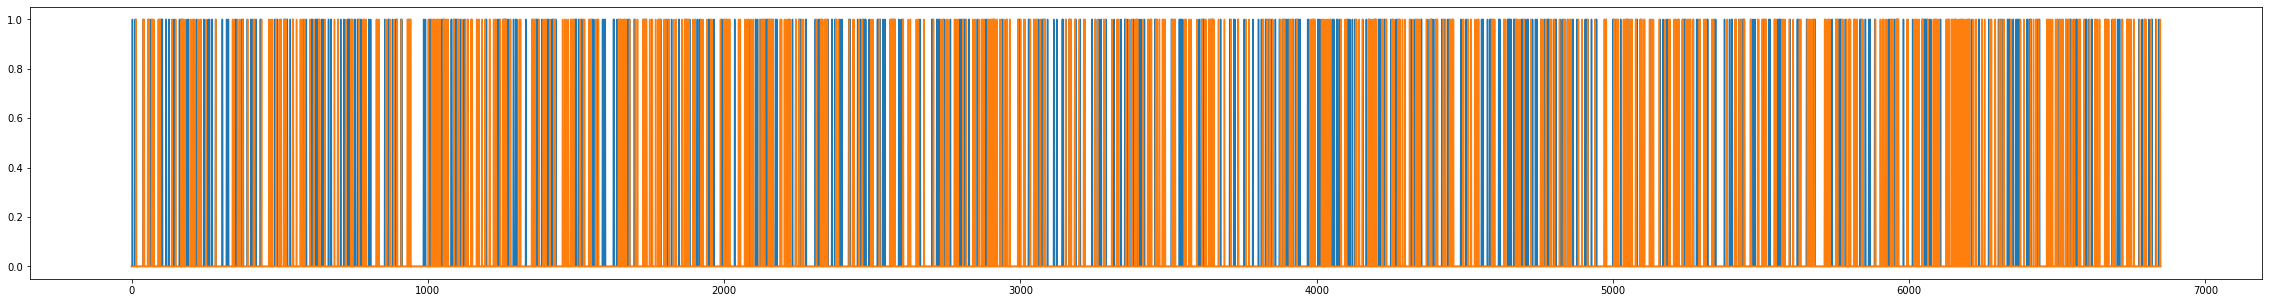

In [60]:
nu = 0.1
pred = np.random.choice(np.arange(2), len(true), p=[1-nu, nu])
evaluate(label_all, pred, adjust=True, plot=True, print_=True)

## OCSVM

In [4]:
from sklearn.svm import OneClassSVM

In [5]:
class StandardScaler():
    """
    Standard the input
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return (data * self.std) + self.mean


data = {}
for category in ['train', 'val', 'test']:
    # train = np.load('/media/usr/SSD/jiin/naver/data/METR-LA/train.npz')
    # val = np.load('/media/usr/SSD/jiin/naver/data/METR-LA/val.npz')
    # test = np.load('/media/usr/SSD/jiin/naver/data/METR-LA/test_anomaly.npz')
    if category != 'train':
        dataset = np.load('/media/usr/SSD/jiin/naver/data/METR-LA/{}.npz'.format(category+'_anomaly'))
    else:
        dataset = np.load('/media/usr/SSD/jiin/naver/data/METR-LA/{}.npz'.format(category))
    data[category+'_x'] = dataset['x']
    data[category+'_y'] = dataset['y']
scaler = StandardScaler(mean = data['train_x'][:, :, :, 0].mean(), std=data['train_x'][:, :, :, 0].std())
for category in ['train', 'val', 'test']:
    data[category+'_x'][...,0] = scaler.transform(data[category+'_x'][..., 0])


train_data, test_data = [], []
train_len = len(data['train_x'])
test_len = len(data['test_x'])
for i in tqdm(range(train_len)): 
    train_data.append(torch.FloatTensor(data['train_x'][i, :, :, 0]).transpose(1,0))
for i in tqdm(range(test_len)): 
    test_data.append(torch.FloatTensor(data['test_x'][i, :, :, 0]).transpose(1,0))
train_data = np.stack(train_data).reshape(train_len, -1)
test_data = np.stack(test_data).reshape(test_len, -1)

100%|██████████| 6850/6850 [00:00<00:00, 54055.90it/s]


In [6]:
train_data.shape, test_data.shape

((23974, 2484), (6850, 2484))

In [32]:
clf = OneClassSVM(gamma='auto').fit(train_data[:10000])

In [33]:
true = data['test_y']
pred = clf.predict(test_data)
pred = [1 if p==1 else 0 for p in pred]

In [34]:
np.unique(true), np.unique(pred)

(array([0, 1]), array([0, 1]))

In [35]:
print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.87      0.72      0.79      6199
           1       0.00      0.00      0.00       651

    accuracy                           0.66      6850
   macro avg       0.44      0.36      0.40      6850
weighted avg       0.79      0.66      0.72      6850



In [38]:
ocsvm_result = []
acc, auc, far, pre, rec, macro_f1, ap = evaluate(true, pred, adjust=False, plot=False)
ocsvm_result.append(['OCSVM', None, None, False, acc, auc, far, pre, rec, macro_f1, ap])
acc, auc, far, pre, rec, macro_f1, ap = evaluate(true, pred, adjust=True, plot=False)
ocsvm_result.append(['OCSVM', None, None, True, acc, auc, far, pre, rec, macro_f1, ap])

ocsvm_result = pd.DataFrame(ocsvm_result, columns=['model', 'normalize', 'nu', 'adjust', 'acc', 'auc', 'far', 'precision', 'recall', 'f1_score', 'AP'])
ocsvm_result

,model,normalize,nu,adjust,acc,auc,far,precision,recall,f1_score,AP
0,OCSVM,None,None,False,0.655036,0.361913,1.0,0.0,0.0,0.395784,0.095036
1,OCSVM,None,None,True,0.655036,0.361913,1.0,0.0,0.0,0.395784,0.095036


Accuracy 	0.6550
AUC score 	0.3619
FAR score 	1.0000
Precision 	0.0000
Recall   	0.0000
Macro F1 	0.3958
Avg Precision 	0.0950
              precision    recall  f1-score   support

           0       0.87      0.72      0.79      6199
           1       0.00      0.00      0.00       651

    accuracy                           0.66      6850
   macro avg       0.44      0.36      0.40      6850
weighted avg       0.79      0.66      0.72      6850



[0.655036496350365,
 0.3619132118083562,
 1.0,
 0.0,
 0.0,
 0.3957837170327247,
 0.09503649635036496]

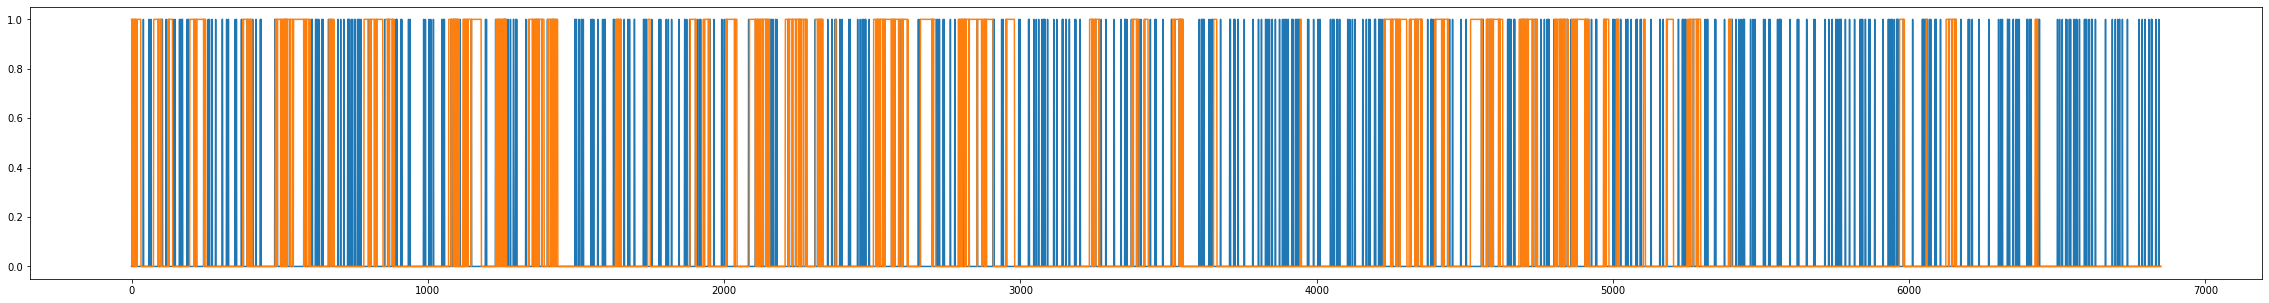

In [36]:
evaluate(true, pred, adjust=True, plot=True, print_=True)

### ARIMA

In [1]:
from statsmodels.tsa.arima.model import ARIMA

In [17]:
class StandardScaler():
    """
    Standard the input
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return (data * self.std) + self.mean

data = {}
for category in ['train', 'val', 'test']:
    if category != 'train':
        dataset = np.load('/media/usr/SSD/jiin/naver/data/METR-LA/{}.npz'.format(category+'_anomaly'))
    else:
        dataset = np.load('/media/usr/SSD/jiin/naver/data/METR-LA/{}.npz'.format(category))
    data[category+'_x'] = dataset['x']
    data[category+'_y'] = dataset['y']
scaler = StandardScaler(mean = data['train_x'][:, :, :, 0].mean(), std=data['train_x'][:, :, :, 0].std())
for category in ['train', 'val', 'test']:
    data[category+'_x'][...,0] = scaler.transform(data[category+'_x'][..., 0])

In [24]:
val_old = np.load('/media/usr/SSD/jiin/naver/data/METR-LA/val.npz')
val_y_old = val_old['y']
val_y_old.shape

(3425, 12, 207, 2)

In [25]:
data['val_x'].shape

(3425, 12, 207, 2)

In [28]:
dev_all = []
for i in tqdm(range(len(data['val_x']))):
    x = data['val_x'][i]
    y = val_y_old[i]
    for n in range(x.shape[1]):
        model = ARIMA(x[:, n, 0], order=(1,1,1))
        results = model.fit()
        pred = results.forecast(12)
        dev_all.append(np.abs(y[:, n, 0] - pred))

100%|██████████| 3425/3425 [8:25:13<00:00,  8.85s/it]  


In [ ]:
df_pred = []
for i in tqdm(range(test_df.shape[0]-24)):
    model = ARIMA(test_df.iloc[i:i+24][accident_sid], order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()
    pred = results.forecast(1)
    df_pred.append(pred)
df_pred = pd.DataFrame(df_pred)
# df_pred.columns=df_test.columns

100%|████████████████████████████████████████████████████████████████████████████████████████| 25896/25896 [07:36<00:00, 56.69it/s]
